In [447]:
import glob
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ics import Calendar
import requests


from sklearn import datasets, linear_model, ensemble, neural_network
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from pathlib import Path

### Get holidays for Austria

In [453]:
url = "https://www.feiertage-oesterreich.at/content/kalender-download/force-download.php"
c = Calendar(requests.get(url).text)

In [ ]:
index = pd.date_range(start='2015-01-01', end='2020-12-31', freq='H')
all_years = pd.DataFrame(index=index, columns=['A'])
all_years["Date"] = pd.to_numeric(all_years.index.strftime('%Y%m%d').values)

all_years.index=all_years["Date"]

events = c.events

dates = []

for event in events:
    dates.append(event.begin)
    
    date = int(event.begin.strftime('%Y%m%d'))
    dates.append(date)
    

dates = dates[1::2]    
dates = dates + [20150101, 20150106, 20150501, 20150815, 20151026, 20151225, 20151226]
dates = dates + ([20160101, 20160106, 20160501, 20160815, 20161026, 20161225, 20161226])
dates = dates + ([20170101, 20170106, 20170501, 20170815, 20171026, 20171225, 20171226])
dates = dates + ([20180101, 20180106, 20180501, 20180815, 20181026, 20181225, 20181226])
dates = dates + ([20190101, 20190106, 20190501, 20190815, 20191026, 20191225, 20191226])
dates = dates + ([20200101, 20200106, 20200501, 20200815, 20201026, 20201225, 20201226])

holidays = pd.DataFrame(columns=['Dates'])
    
holidays['Dates'] = dates
holidays.index = holidays['Dates']

all_years_holidays = all_years.join(holidays)
all_years_holidays.index = pd.date_range(start='2015-01-01', end='2020-12-31', freq='H')
all_years_holidays["is_holiday"] = np.isnan(all_years_holidays["Dates"])==False

In [ ]:
all_years_holidays

## Load data

Has to be downloaded previously. Here, we ask for the path to the folder, where the ENTSO-E data resides.

In [ ]:
CONFIG_FILE = '../entsoe-data.config'

if not os.path.exists(CONFIG_FILE):
    download_dir = input('Path to ENTSO-E data folder: ')
    if not os.path.isdir(download_dir):
        raise RuntimeError(f'Invalid download_dir, please run cell again: {download_dir}')
    with open(CONFIG_FILE, 'w') as f:
        f.write(download_dir)
else:
    with open(CONFIG_FILE) as f:
        download_dir = f.read()
        
# Clear the output after this cell if you want to aovid having your path in the notebook (or execute it twice)!

In [ ]:
def read_single_csv_entso_e(file):
    return pd.read_csv(file, sep='\t', encoding='utf-16', parse_dates=["DateTime"])


def load_complete_entso_e_data(directory):
    pattern = Path(directory) / '*.csv'
    files = glob.glob(str(pattern))

    if not files:
        raise ValueError(f"No files found when searching in {pattern}, wrong directory?")
    
    print(f'Concatenating {len(files)} csv files...')

    each_csv_file = [read_single_csv_entso_e(file) for file in files]
    data = pd.concat(each_csv_file, ignore_index=True)

    data = data.sort_values(by=["AreaName", "DateTime"])
    data = data.set_index("DateTime")

    print("Loading done.")

    return data


power_demand = load_complete_entso_e_data(download_dir)

## Extract hourly data for Austria

Additionally, we join the hourly data with the information on holidays.

In [ ]:
def get_hourly_country_data(data, country):
    ret_data = data[data["AreaName"] == country].interpolate() # data may contain NAs, therefore inteprolate
    ret_data = ret_data.resample("1h").mean().interpolate() # not all hours may be  complete 
                                                            # (i.e. some last 15 minutes are lacking, therefore another inpolation here)

    return ret_data

power_demand_at_hourly = get_hourly_country_data(power_demand, "Austria")["2016-01-01":"2019-12-31"]
power_demand_at_hourly = power_demand_at_hourly.join(all_years_holidays)

## Setting up regression model

Here, we setup the regression model. In a first step, we extract our output feature, i.e. target, from the dataset (the hourly load) and save it into a numpy array, as this is the format required by the scikit-learn models.

In [ ]:
def get_Y(data):
    Y = np.array(data["TotalLoadValue"]).reshape(-1, 1)
    
    return Y

Y = get_Y(power_demand_at_hourly)

In a second step we define the input features, which consist of dummy variables for hours, days, and holidays - and of a sinus and cosinus term which allows to model annual seasonality.

In [ ]:
def get_X(data, has_trend = False):

    weekly_dummies = np.array(pd.get_dummies(
        data.index.week))
    #[:, :11]
    cos = np.cos(2 * np.pi * ((data.index.dayofyear.values - 1) * 24 + data.index.hour.values) / 8760)
    sin = np.sin(2 * np.pi * ((data.index.dayofyear.values - 1) * 24 + data.index.hour.values) / 8760)
    
    weekday = np.array(pd.get_dummies(
        data.index.weekday))
    #[:, :6]

    hour = np.array(pd.get_dummies(
        data.index.hour))
    
    holiday = np.array(pd.get_dummies(data["is_holiday"]))
    #[:, :23]

    trend = np.arange(0, len(hour)).reshape(-1, 1)
    
   
    X_out = np.append(hour, weekday, axis=1)
    X_out = np.append(X_out, holiday, axis=1)
    X_out = np.append(X_out, weekly_dummies, axis=1)
    X_out = np.append(X_out, cos.reshape(-1, 1), axis=1)
    
    if(has_trend):
        X_out = np.append(X_out, trend, axis=1)
    
    return X_out
        
    
X = get_X(power_demand_at_hourly)


Fit the model, calculate the prediction for the training period, plot observation and prediction and residues.

In [ ]:
def train_model(X_training, X_test, Y_training, Y_test):
    regr = linear_model.LinearRegression(fit_intercept=False)

    # Train the model using the training sets
    regr.fit(X_training, Y_training)

    pred = regr.predict(X_test)


    plt.plot(Y_test)
    plt.plot(pred, alpha=0.7)
    
    
    residues = Y_test - pred
    plt.plot(residues)
    print(r2_score(Y_test, pred))
    plt.show()
    
    plt.plot(pred[400:800], alpha=0.7)

    plt.plot(Y_test[400:800])
    plt.show()
    
    return pred, residues, regr
    
#power_demand_at_hourly["Prediction"] = pred
#power_demand_at_hourly["TotalLoadValue"].resample('1m').mean().plot()
#power_demand_at_hourly["Prediction"].resample('1m').mean().plot()
    
    

## Random train-test split

In [ ]:
X_training, X_test, Y_training, Y_test = train_test_split(X, Y, test_size=0.20)
pred, residues, regr = train_model(X_training, X_test, Y_training, Y_test)

## 3 years train, 1 year test split

0.8626614613946832


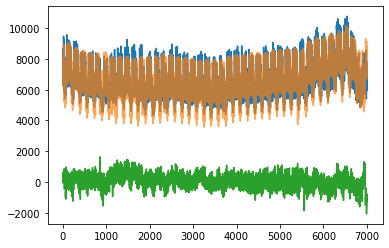

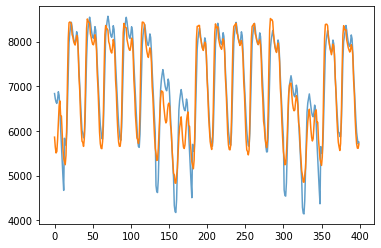

In [424]:
len_tot = X.shape[0]
ics_test = np.arange(0, int(len_tot * 0.2)) 
ics_training = np.arange(int(len_tot*0.2), len_tot)
ics_training

X_training = X[ics_training, :]
Y_training = Y[ics_training, :]
X_test = X[ics_test, :]
Y_test = Y[ics_test, :]


pred, residues, regr = train_model(X_training, X_test, Y_training, Y_test)


## Train on whole period and test on whole period 

0.8933376437388617


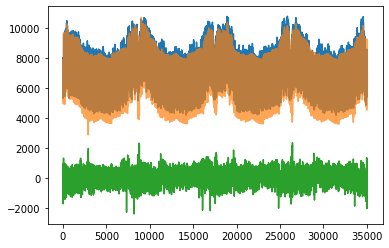

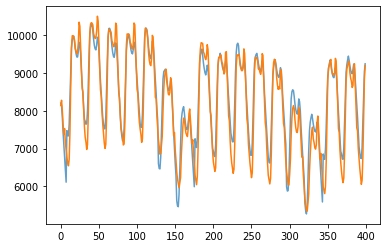

In [425]:
pred, residues, regr = train_model(X, X, Y, Y)

We may want to zoom in a little bit:

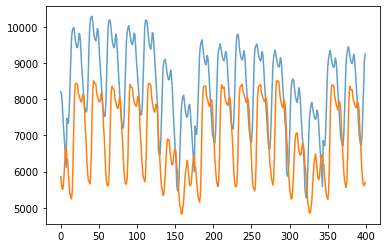

In [426]:
plt.plot(pred[400:800], alpha=0.7)

plt.plot(Y_test[400:800])

A monthly aggregation shows well the long-term quality of the fit:

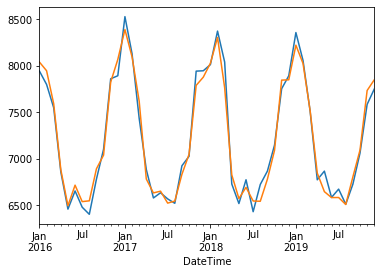

In [427]:
power_demand_at_hourly["Prediction"] = pred
power_demand_at_hourly["TotalLoadValue"].resample('1m').mean().plot()
power_demand_at_hourly["Prediction"].resample('1m').mean().plot()

## Temperature data

Now we add temperature data. First we load the data from disk:

In [ ]:
import xarray as xr
data = xr.load_dataset("../data/temperatures_era5_levels.nc")
temp_data = data.t2m.sel(longitude=16.5, latitude=48)
plt.plot(temp_data)



We select the correct time slice, convert to degree celsius (as temperature is given in degree kelvin). Finally, we limit the maximum temperature to a maximum temperature, as we expect that the temperature effect on load is leveling off there (see cell below). To determine at which temperature we should set the cut-off, we calculate the correlation between residues of the first regression model with temperatures and pick the temperature, where correlation is highest.

In [433]:
temp_data_year = temp_data.sel(time=slice('2016-01-01', '2019-12-31'))

cors = []
for i in range(0, 40):
    limit_heating = i
    temp_data_year_np = temp_data_year.values[:, 0] - 273.15

    temp_data_year_np[temp_data_year_np > limit_heating] = limit_heating
    one_cor = np.corrcoef(temp_data_year_np, residues.reshape(-1,))[0, 1]
    cors.append(one_cor)

    
max_heating_temperature = np.argmin(cors) + 1 
print(f'Max heating temperature chosen:{max_heating_temperature}')   

temp_data_year_np = temp_data_year.values[:, 0] - 273.15
    
temp_data_year_np[(temp_data_year_np > max_heating_temperature)] = max_heating_temperature

0.016440443930304457
0.018373271859467882
0.01837817292808936
0.015912363880130814
0.012337144393943813
0.0071176453535131985
-0.00033838309712059687
-0.009283659552263927
-0.01873033013557772
-0.028564051518263512
-0.03815079213198651
-0.04725410791592851
-0.055112214795014144
-0.06181473895593147
-0.06760940956834557
-0.07232898027007599
-0.07612447209851414
-0.07924248368689292
-0.08169409500889421
-0.08352969021598869
-0.08489114685708128
-0.08567885897120477
-0.08607012508949274
-0.0859222517623795
-0.08542887964748351
-0.08460307406073354
-0.08353032487870192
-0.08242445837589032
-0.0813839128709194
-0.08036394737059445
-0.07942976120602636
-0.07868067403410335
-0.07813248890477731
-0.0777912645190284
-0.07762426877306534
-0.07754896677671548
-0.07750492827978474
-0.07748104090367515
-0.0774783303585414
-0.0774783303585414
Max heating temperature chosen:23


Scatterplot of residues of previous regression model and temperaturs, constrained by max_heating_temperature.

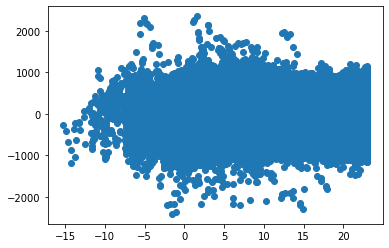

In [434]:
plt.scatter(temp_data_year_np, residues)

We now want to train the model with temperature. We therefore add the temperature timeseries to X.

In [435]:
X = get_X(power_demand_at_hourly)
X = np.append(X, temp_data_year_np.reshape(-1, 1), axis=1)

In [436]:
len_tot = X.shape[0]
ics_training = np.arange(0, int(len_tot * 0.8)) 
ics_test = np.arange(int(len_tot*0.8), len_tot)
ics_training

X_training = X[ics_training, :]
Y_training = Y[ics_training, :]
X_test = X[ics_test, :]
Y_test = Y[ics_test, :]

0.8732093237083116


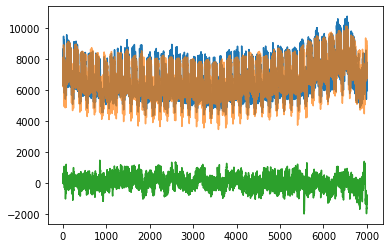

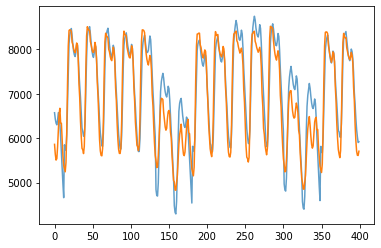

In [437]:
pred, residues, regr = train_model(X_training, X_test, Y_training, Y_test)


Well, this improved things a little bit. Let's have a look at monthly data.

0.9002257238609974


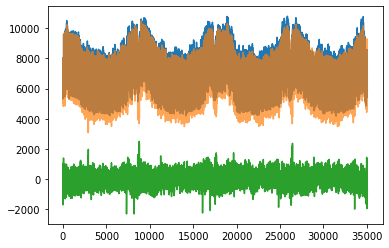

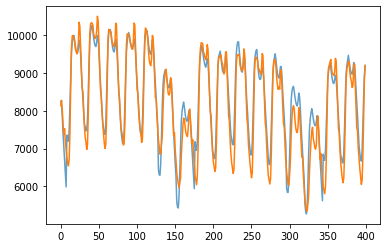

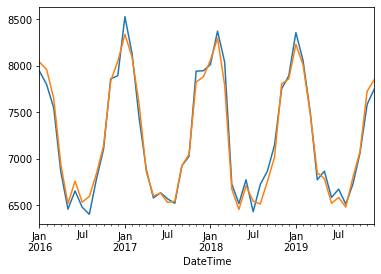

In [438]:
pred, residues, regr = train_model(X, X, Y, Y)


power_demand_at_hourly["Prediction"] = pred
power_demand_at_hourly["TotalLoadValue"].resample('1m').mean().plot()
power_demand_at_hourly["Prediction"].resample('1m').mean().plot()

## Model for 2020
Looks ok-ish! We use this model to predict 2020 load now. First get observations from 2020.

In [439]:
power_demand_at_hourly_2020 =  get_hourly_country_data(power_demand, "Austria")["2020-01-01":"2020-05-20"]


Create a data-frame for prediction. We need the whole year, so we can generate the correct input for seasonal adjustment (if in particular monthly dummies would be used).

In [441]:
index = pd.date_range(start='2020-01-01', end='2020-12-31', freq='H')
year_2020 = pd.DataFrame(index=index).join(all_years_holidays)
X_2020 = get_X(year_2020)

Get the temperature data for 2020 and adjust it.

In [442]:
temp_data_year = temp_data.sel(time=slice('2020-01-01', '2020-05-20'))

temp_data_year_np = temp_data_year.values[:, 0] 
temp_data_year_np = temp_data_year.values[:, 0] 
temp_data_year_np[np.isnan(temp_data_year_np)] = temp_data_year.values[np.isnan(temp_data_year_np), 1]

temp_data_year_np = temp_data_year_np - 273.15

temp_data_year_np[(temp_data_year_np > max_heating_temperature)] = max_heating_temperature

temp_reshaped = temp_data_year_np.reshape(-1, 1)

Add temperature to input features.

In [443]:
X_2020 = X_2020[:temp_reshaped.shape[0], :]
X_2020 = np.append(X_2020, temp_reshaped, axis=1)

0.9002257238609974


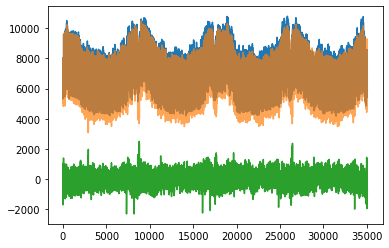

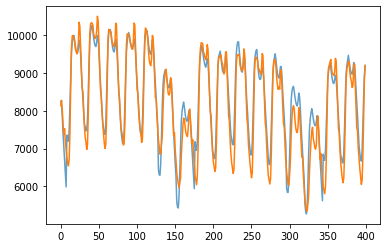

In [450]:
pred, residues, regr = train_model(X, X, Y, Y)

prediction_2020 = regr.predict(X_2020)

power_demand_at_hourly_2020["prediction"] = prediction_2020


Text(0, 0.5, 'Proportion of Observed Load to Predicted Load (%)')

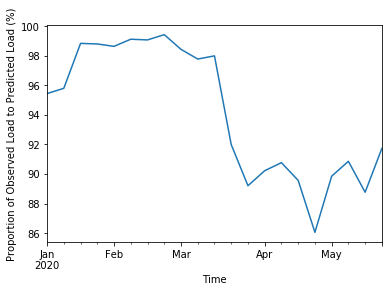

In [451]:
(100*power_demand_at_hourly_2020["TotalLoadValue"]/power_demand_at_hourly_2020["prediction"]).resample('1w').mean().plot()
plt.xlabel("Time")
plt.ylabel("Proportion of Observed Load to Predicted Load (%)")

Text(0.5, 0, 'Time')

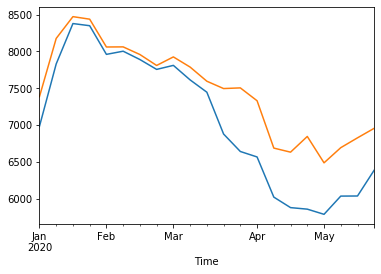

In [452]:
prediction_2020 = regr.predict(X_2020)

power_demand_at_hourly_2020["prediction"] = prediction_2020

(power_demand_at_hourly_2020["TotalLoadValue"]).resample('1w').mean().plot()
(power_demand_at_hourly_2020["prediction"]).resample('1w').mean().plot()

plt.xlabel("Time")
